In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import random

from auxiliaries import *

random.seed(34)

### Auxiliary functions

In [ ]:
# types of routes
types = {
    0: "tram",
    1: "subway",
    2: "rail",
    3: "bus",
    4: "ferry",
    5: "walking",
}

def distance_to_duration(d):
    """
    Converts the distance to duration
    :param d: distance
    :return: duration
    """
    # average walking speed set to 1.3m/s
    speed = 1.3
    return d / speed

def euclidian_distance(G, a, b):
    """
    Calculates the (approximate) euclidian distance between two nodes
    :param a: node a
    :param b: node b
    :param G: graph
    :return: distance
    """
    x1, y1 = G.nodes[a]["pos"]
    x2, y2 = G.nodes[b]["pos"]
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)/1.6

def closest_node_pair(G, subgraph):
    """
    Finds the closest node outside of the subgraph
    :param G: graph
    :param subgraph: subgraph
    :return: closest node pair
    """
    # find the nodes outside of the subgraph
    nodes_outside = [n for n in G.nodes if n not in subgraph.nodes]
    # find the closest node pair between the nodes outside and the nodes inside
    closest_node_pair = min(
        [(n1, n2) for n1 in nodes_outside for n2 in subgraph.nodes],
        key=lambda x: euclidian_distance(G, x[0], x[1]),
    )
    # return the closest node pair
    return closest_node_pair


In [ ]:
def make_walking_connected(G, G_walk):
    """
    Makes the graph connected by adding walking edges
    :param G: graph
    :param G_walk: graph with walking edges
    :return: None
    """
    # add all nodes that are in G but not in G_walk to G_walk
    for n in G.nodes:
        if n not in G_walk.nodes:
            G_walk.add_node(n, pos=G.nodes[n]["pos"])
    while not nx.is_connected(G_walk):
        # find the second largest connected component
        second_largest_cc = sorted(
            nx.connected_components(G_walk), key=len, reverse=True
        )[1]
        # find the closest node outside of the second largest connected component
        closest_node = closest_node_pair(G, G_walk.subgraph(second_largest_cc))
        # add the edge between the closest node and the second largest connected component
        # set duration to euclidian distance between the two nodes
        # set route_type to 5 (walking)
        G_walk.add_edge(
            closest_node[0],
            closest_node[1],
            duration=euclidian_distance(G, closest_node[0], closest_node[1]),
            route_type=5,
        )
        G.add_edge(
            closest_node[0],
            closest_node[1],
            duration=euclidian_distance(G, closest_node[0], closest_node[1]),
            route_type=5,
        )

### Functions for experiments

In [ ]:
def travel_time(G, a, b):
    """Rough estimate of travel time between two nodes."""
    return nx.shortest_path_length(G, a, b, weight="duration_avg")


def average_travel_time(G):
    """Average travel time between all pairs of nodes in G."""
    return nx.average_shortest_path_length(G, weight="duration_avg")


def full_average_travel_time(G):
    """
    calculate average travel time for each component of G
    and weight it by the number of nodes in the component
    """
    components = nx.connected_components(G)
    total = 0
    for component in components:
        total += len(component) * average_travel_time(G.subgraph(component))
    return total / len(G)


def random_sample(nodes, size):
    """
    Randomly sample a subset of nodes from the graph.
    """
    # take sample of nodes
    sample = []
    for i in range(size):
        sample.append(random.sample(list(nodes), 2))
    return sample


def sample_average_travel_time(sample, G):
    """
    Average travel time between all pairs of nodes in the sample.
    """
    # for each pair in sample, calculate shortest path length in G
    # and average over all pairs
    total = 0
    for pair in sample:
        total += travel_time(G, pair[0], pair[1])
    return total / (len(sample))

## Percolation functions
#### Random percolation

In [ ]:
# function to perform random percolation on a graph
def random_percolation(G, p):
    """
    Random percolation on a graph.
    :param G: graph
    :param p: probability of edge removal
    """
    to_remove = []
    G_copy = G.copy()
    for edge in G_copy.edges(keys=True):
        source, target, key = edge[0], edge[1], edge[2]
        edgetype = G_copy.get_edge_data(source, target, key)["route_type"]
        # exclude walking edges
        if edgetype != 5 and random.random() < p:
            to_remove.append((source, target, key))
    for edge in to_remove:
        source, target, key = edge[0], edge[1], edge[2]
        G_copy.remove_edge(source, target, key=key)
    return G_copy

#### TODO: Targeted percolation

In [327]:
# targeted percolation on a graph
def targeted_percolation(G, p, nodes):

    # remove edges from nodes in order, until probability p edges are removed
    # exclude walking edges
    G_copy = G.copy()
    to_remove = []
    for node in nodes:
        for edge in G_copy.edges(node, keys=True):
            source, target, key = edge[0], edge[1], edge[2]
            edgetype = G_copy.get_edge_data(source, target, key)["route_type"]
            if edgetype != 5:
                to_remove.append((source, target, key))
        if len(to_remove) / len(G_copy.edges) >= p:
            break
    for edge in to_remove:
        source, target, key = edge[0], edge[1], edge[2]
        G_copy.remove_edge(source, target, key=key)
    return G_copy

def get_nodes(G, method="degree"):
    print("Getting nodes...\n")
    if method == "eigenvector":
        # sort nodes by eigenvector centrality
        nodes = sorted(
            G.nodes, key=lambda x: nx.eigenvector_centrality(G)[x], reverse=True
        )
    elif method == "betweenness":
        # sort nodes by betweenness centrality
        nodes = sorted(
            G.nodes, key=lambda x: nx.betweenness_centrality(G)[x], reverse=True
        )
    elif method == "closeness":
        # sort nodes by closeness centrality
        nodes = sorted(
            G.nodes, key=lambda x: nx.closeness_centrality(G)[x], reverse=True
        )
    else: # method == "degree":
        # sort nodes by degree
        nodes = sorted(G.nodes, key=lambda x: G.degree[x], reverse=True)
    return nodes

#### Repeated experiments

In [329]:
# Repeated experiments
import numpy as np

def percolation_experiments(G, p_min, p_max, steps, n_tests, n_percolations, method="random", verbose=False):
    """
    Repeated percolation experiments.
    :param G: graph
    :param p_min: minimum probability
    :param p_max: maximum probability
    :param steps: number of steps
    :param n: number of repetitions
    """
    # initiate dataframe for results
    results = pd.DataFrame(columns=['p', 'perc', 'test', 'result'])
    # make range of probabilities
    p_range = np.linspace(p_min, p_max, steps)

    if not method == "Random":
        nodes = get_nodes(G, method=method)
    else:
        nodes = None

    if verbose:
        print("Starting experiments...\n")
    experiment = 0
    for test in range(n_tests):
        sample = random_sample(G.nodes, 100)
        for p in p_range:
            for i in range(n_percolations):
                if method == "random":
                    G_perc = random_percolation(G, p)
                else:
                    G_perc = targeted_percolation(G, p, nodes)
                    
                time = sample_average_travel_time(sample, G_perc)

                # append result to dataframe
                results.loc[experiment] = (p, i, test, time)
                if verbose:
                    print("p: {}, test: {}, time: {}, perc: {}".format(p, test, time, i))
                experiment += 1

    return results

## Performing experiments on Berlin network

In [313]:
# read in public transport network of berlin and walking network
berlin, berlin_nodes = read_in_network("berlin", "combined")
berlin_walking, nodes_t = read_in_network("berlin", "walk")

# adapt berlin_walking dataframe to match berlin dataframe
berlin_walking = berlin_walking.rename(columns={"d_walk": "duration_avg"})
berlin_walking["duration"] = berlin_walking["duration_avg"].apply(distance_to_duration)
berlin_walking["n_vehicles"] = 0
berlin_walking["route_I_counts"] = 0
berlin_walking["route_type"] = 5

# add berlin_walking to berlin
berlin_full = pd.concat([berlin, berlin_walking], ignore_index=True)

In [314]:
# convert to graph
G = convert_to_graph(berlin_full)
pos = add_positions(G, berlin_nodes)

# convert walking network to seperate graph
G_walk = convert_to_graph(berlin_walking)

# make G connected by adding walking edges
make_walking_connected(G, G_walk)

#### Perform percolation experiment

In [323]:
results = percolation_experiments(G, 0, 1, 20, 1, 5, verbose=True)

In [334]:
results_betweenness = percolation_experiments(G, 0, 1, 20, 1, 5, method="degree", verbose=True)

Getting nodes...

Starting experiments...

p: 0.0, test: 0, time: 2109.5876928452813, perc: 0
p: 0.0, test: 0, time: 2109.5876928452813, perc: 1
p: 0.0, test: 0, time: 2109.5876928452813, perc: 2
p: 0.0, test: 0, time: 2109.5876928452813, perc: 3
p: 0.0, test: 0, time: 2109.5876928452813, perc: 4


NetworkXError: The edge 10429-188 is not in the graph.

#### Plot results

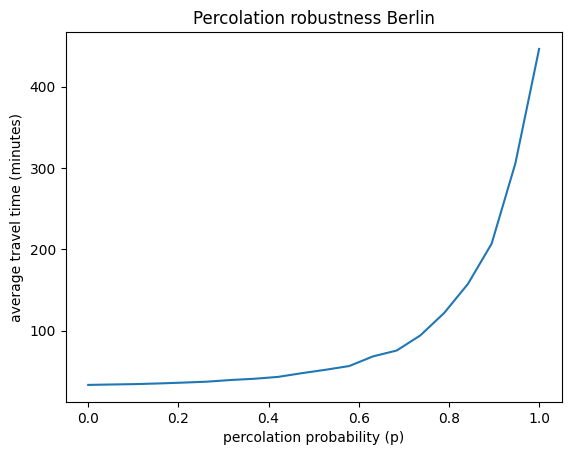

In [319]:
# make graph plotting p range against average average travel time
x = results.groupby("p").mean().reset_index()["p"]
# divide y by 60 to get minutes
y = results.groupby("p").mean().reset_index()["result"]/60
# set x and y label
plt.xlabel("percolation probability (p)")
plt.ylabel("average travel time (minutes)")
plt.title("Percolation robustness Berlin")
plt.plot(x, y)